In [3]:
# !pip install awswrangler
# !pip install holidays
# !apt-get update -qq
# !apt-get install fonts-nanum* -qq

# import matplotlib.pyplot as plt
# import matplotlib as mpl
# %matplotlib inline
# plt.rcParams['axes.unicode_minus'] = False
# path = '/usr/share/fonts/truetype/nanum/NanumGothic.ttf'
# font_name = mpl.font_manager.FontProperties(fname=path).get_name()
# mpl.rc('font', family=font_name)
# mpl.font_manager._rebuild()

## Data Load

In [4]:
import awswrangler as wr
import pandas as pd
import numpy as np
import holidays
import matplotlib.pyplot as plt
from datetime import datetime
import boto3
from sklearn.impute import KNNImputer
from sklearn.metrics import mean_squared_error

In [36]:
## 2016 ~ 2022 7년간 데이터
df = wr.s3.read_csv('s3://sagemaker-eightmeals/raw_data/pigprice(2016-2022)_20230201.csv')
df['date'] = pd.to_datetime(df['date']) ## Date 형변환

## EDA

In [ ]:
df.shape

(15228, 38)

In [38]:
list(df)

['date',
 '등급',
 '가격_전체',
 '두수_전체',
 '가격_제주제외전체',
 '두수_제주제외전체',
 '가격_수도권',
 '두수_수도권',
 '가격_도드람',
 '두수_도드람',
 '가격_협신식품',
 '두수_협신식품',
 '가격_삼성식품',
 '두수_삼성식품',
 '가격_농협부천',
 '두수_농협부천',
 '가격_영남권',
 '두수_영남권',
 '가격_김해축공',
 '두수_김해축공',
 '가격_부경축공',
 '두수_부경축공',
 '가격_신흥산업',
 '두수_신흥산업',
 '가격_농협고령',
 '두수_농협고령',
 '가격_호남권',
 '두수_호남권',
 '가격_익산',
 '두수_익산',
 '가격_농협나주',
 '두수_농협나주',
 '가격_삼호축산',
 '두수_삼호축산',
 '가격_농협음성',
 '두수_농협음성',
 '가격_제주축협',
 '두수_제주축협']

In [39]:
## 요일 & 공휴일별 공백값 확인
df['weekday'] = df['date'].dt.weekday   ## 요일 데이터 추출

kr_holidays = holidays.KR()             ## 한국 휴일 객체 생성 
df['holiday'] = df.date.apply(lambda x: 'holiday' if x in kr_holidays else 'non-holiday') ## generate holiday table


temp_df = df[df['가격_전체'].isna()]
weekday_df = temp_df['weekday'].value_counts().reset_index().sort_values(['index'])
weekday_df = pd.merge(weekday_df, 
                      df['weekday'].value_counts().reset_index().sort_values(['index']), 
                      left_on = 'index', 
                      right_on='index')
weekday_df['weekday_rate'] = weekday_df['weekday_x']/weekday_df['weekday_y']
weekday_df[['weekday_x','weekday_rate']]


holiday_df = temp_df['holiday'].value_counts().reset_index().sort_values(['index'])
holiday_df = pd.merge(holiday_df, 
                      df['holiday'].value_counts().reset_index().sort_values(['index']), 
                      left_on = 'index', 
                      right_on='index')

holiday_df['holiday_rate'] = holiday_df['holiday_x']/holiday_df['holiday_y']
holiday_df[['holiday_x','holiday_rate']]

,holiday_x,holiday_rate
0,557,0.767218
1,4128,0.284650


In [40]:
df['date'].min(), df['date'].max()

(Timestamp('2016-01-01 00:00:00'), Timestamp('2022-12-31 00:00:00'))

In [41]:
## 등급별 결측치 확인 -> 모돈을 제외한 나머지 등급에 대한 예측 진행 (다른 등급과 모돈의 결측치 차이 약 2배)
nan_rank = pd.DataFrame(columns = ['grade','zero_num','zero_rate'])
for grade in df['등급'].unique():
    temp_df = df[df['등급'] == grade].copy()
    print(f"NaN values in {grade} : {temp_df.isna().sum().sum()}")
    print(f"NaN rate in {grade} : {round(temp_df.isna().sum().sum()/len(temp_df),2)}")
    nan_rank = nan_rank.append({'grade' : grade,
                                'zero_num' : temp_df.isna().sum().sum(),
                                'zero_rate' : round(temp_df.isna().sum().sum()/len(temp_df),2)},
                               ignore_index = True)                
nan_rank.sort_values(['zero_rate'])

NaN values in 1+ : 35196
NaN rate in 1+ : 13.87
NaN values in 1 : 34966
NaN rate in 1 : 13.78
NaN values in 2 : 34840
NaN rate in 2 : 13.73
NaN values in 등외 : 41430
NaN rate in 등외 : 16.32
NaN values in 등외제외 : 34812
NaN rate in 등외제외 : 13.72
NaN values in 모돈 : 78967
NaN rate in 모돈 : 31.11


,grade,zero_num,zero_rate
4,등외제외,34812,13.72
2,2,34840,13.73
1,1,34966,13.78
0,1+,35196,13.87
3,등외,41430,16.32
5,모돈,78967,31.11


In [42]:
## 전체 컬럼별 공백값 비율 확인 (전체 가격/두수에 대한 결측치 값이 가장 적음)
nan_rank = pd.DataFrame(columns = ['col','zero_num','zero_rate'])
for col in list(df)[2:-2]:
    if '가격' in col:
        print(f'col {col} Zero num : {df[df[col].isna()].shape}')
        print(f'col {col} Zero rate : {round(df[df[col].isna()].shape[0]/len(df), 2)}')
        nan_rank = nan_rank.append({'col' : col,
                                    'zero_num' : df[df[col].isna()].shape[0],
                                    'zero_rate' : round(df[df[col].isna()].shape[0]/len(df), 2)},
                                   ignore_index = True)
nan_rank.sort_values(['zero_rate'])

col 가격_전체 Zero num : (4685, 40)
col 가격_전체 Zero rate : 0.31
col 가격_제주제외전체 Zero num : (4850, 40)
col 가격_제주제외전체 Zero rate : 0.32
col 가격_수도권 Zero num : (6502, 40)
col 가격_수도권 Zero rate : 0.43
col 가격_도드람 Zero num : (7366, 40)
col 가격_도드람 Zero rate : 0.48
col 가격_협신식품 Zero num : (7143, 40)
col 가격_협신식품 Zero rate : 0.47
col 가격_삼성식품 Zero num : (7738, 40)
col 가격_삼성식품 Zero rate : 0.51
col 가격_농협부천 Zero num : (11084, 40)
col 가격_농협부천 Zero rate : 0.73
col 가격_영남권 Zero num : (5692, 40)
col 가격_영남권 Zero rate : 0.37
col 가격_김해축공 Zero num : (7921, 40)
col 가격_김해축공 Zero rate : 0.52
col 가격_부경축공 Zero num : (6281, 40)
col 가격_부경축공 Zero rate : 0.41
col 가격_신흥산업 Zero num : (6312, 40)
col 가격_신흥산업 Zero rate : 0.41
col 가격_농협고령 Zero num : (6715, 40)
col 가격_농협고령 Zero rate : 0.44
col 가격_호남권 Zero num : (5687, 40)
col 가격_호남권 Zero rate : 0.37
col 가격_익산 Zero num : (14185, 40)
col 가격_익산 Zero rate : 0.93
col 가격_농협나주 Zero num : (6149, 40)
col 가격_농협나주 Zero rate : 0.4
col 가격_삼호축산 Zero num : (7203, 40)
col 가격_삼호축산 Zero rate : 0.47
col

,col,zero_num,zero_rate
0,가격_전체,4685,0.31
1,가격_제주제외전체,4850,0.32
12,가격_호남권,5687,0.37
7,가격_영남권,5692,0.37
14,가격_농협나주,6149,0.40
17,가격_제주축협,6126,0.40
9,가격_부경축공,6281,0.41
10,가격_신흥산업,6312,0.41
2,가격_수도권,6502,0.43
11,가격_농협고령,6715,0.44


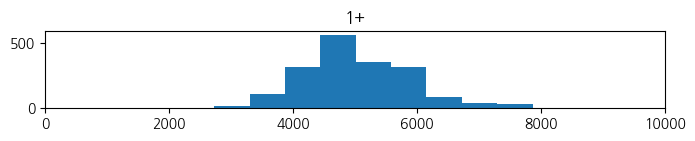

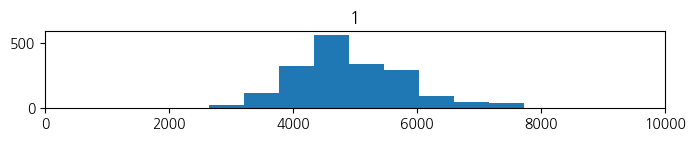

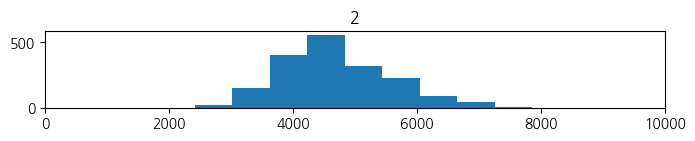

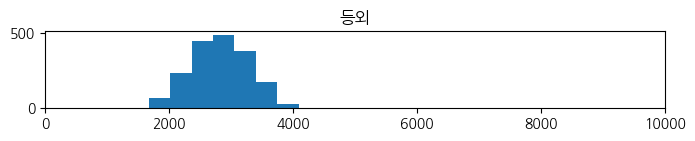

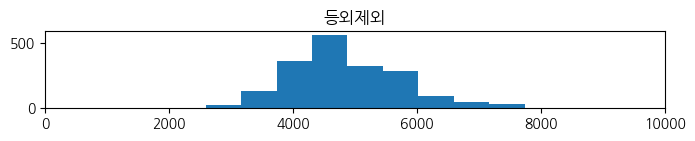

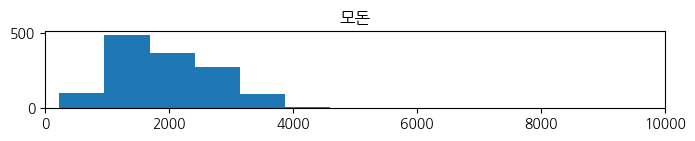

In [43]:
## 등급별 가격 분포 확인 -> 모돈을 제외하고 전반적으로 정규분포를 따르고 있음
for grade in df['등급'].unique():
    plt.figure(figsize = (8,1))
    plt.hist(df[df['등급'] == grade]['가격_전체'])
    plt.xlim(0,10000)
    plt.title(grade)
    plt.show()

In [44]:
## 지역권 별 데이터 분류
sudo = ['date','가격_도드람','두수_도드람','가격_협신식품','두수_협신식품','가격_삼성식품','두수_삼성식품','가격_농협부천','두수_농협부천']
young_nam = ['date','가격_김해축공','두수_김해축공','가격_부경축공','두수_부경축공','가격_신흥산업','두수_신흥산업','가격_농협고령','두수_농협고령']
ho_nam = ['date','가격_익산','두수_익산','가격_농협나주','두수_농협나주','가격_삼호축산','두수_삼호축산']

sudo_df = df[sudo].copy()
young_nam_df = df[young_nam].copy()
ho_nam_df = df[ho_nam].copy()

In [45]:
## 지역별 가격 -> 평균(오차 존재 - 고객사 의견 : 사용 가능), 두수 -> 합계(오차 없음)
target = 'sudo'
df_target = '수도권'

globals()[f'{target}_df']['total_pig'] = globals()[f'{target}_df'][[col for col in globals()[target] if '두수' in col]].sum(axis = 1)
globals()[f'{target}_df']['total_price'] = globals()[f'{target}_df'][[col for col in globals()[target] if '가격' in col]].sum(axis = 1)
globals()[f'{target}_df']['average_pig'] = globals()[f'{target}_df'][[col for col in globals()[target] if '두수' in col]].mean(axis = 1)
globals()[f'{target}_df']['average_price'] = globals()[f'{target}_df'][[col for col in globals()[target] if '가격' in col]].mean(axis = 1)
        
temp_df = pd.merge(globals()[f'{target}_df'], df[[f'가격_{df_target}',f'두수_{df_target}']], left_index = True, right_index = True)
temp_df[(~temp_df[f'가격_{df_target}'].isna())&(temp_df[f'가격_{df_target}'] != temp_df['average_price'])][['total_pig','total_price','average_pig','average_price',f'가격_{df_target}',f'두수_{df_target}']].head()

,total_pig,total_price,average_pig,average_price,가격_수도권,두수_수도권
18,249.0,17968.0,62.25,4492.000000,4290.0,249.0
19,321.0,17215.0,80.25,4303.750000,4210.0,321.0
20,295.0,13894.0,73.75,3473.500000,3548.0,295.0
21,15.0,6673.0,5.00,2224.333333,2642.0,15.0
22,865.0,16033.0,216.25,4008.250000,4011.0,865.0


In [46]:
## 전체 가격 -> 지역구 가격 평균(오차 존재 - 고객사 의견 : 사용 가능)
temp_df = df.copy()

temp_df['지역구_가격_합'] = temp_df[[col for col in list(temp_df) if ('가격' in col)& ('권' in col or '제주축협' in col)]].sum(axis = 1)
temp_df['지역구_가격_평균'] = temp_df[[col for col in list(temp_df) if ('가격' in col)& ('권' in col or '제주축협' in col)]].mean(axis = 1)
temp_df['지역구_두수_합'] = temp_df[[col for col in list(temp_df) if ('두수' in col)& ('권' in col or '제주축협' in col)]].sum(axis = 1)
temp_df['지역구_두수_평균'] = temp_df[[col for col in list(temp_df) if ('두수' in col)& ('권' in col or '제주축협' in col)]].mean(axis = 1)


temp_df[(~temp_df['가격_전체'].isna())&(temp_df['가격_전체']!=temp_df['지역구_가격_합'])][['가격_전체','두수_전체','지역구_가격_합', '지역구_가격_평균','지역구_두수_합', '지역구_두수_평균']].head()

,가격_전체,두수_전체,지역구_가격_합,지역구_가격_평균,지역구_두수_합,지역구_두수_평균
18,4560.0,1048.0,17723.0,4430.75,1005.0,251.25
19,4342.0,1442.0,17253.0,4313.25,1403.0,350.75
20,4049.0,1736.0,15827.0,3956.75,1658.0,414.50
21,2826.0,247.0,11082.0,2770.50,245.0,61.25
22,4279.0,4226.0,16845.0,4211.25,4066.0,1016.50


가격_전체 describe -> min : 2159.0 / max : 7865.0 / std : 872.5856092403393
가격_제주제외전체 describe -> min : 2159.0 / max : 7005.0 / std : 783.882148863346
가격_수도권 describe -> min : 2557.0 / max : 7442.0 / std : 797.6389396685323
가격_영남권 describe -> min : 2366.0 / max : 7143.0 / std : 796.7430111714177
가격_호남권 describe -> min : 2159.0 / max : 6876.0 / std : 791.1941258381607


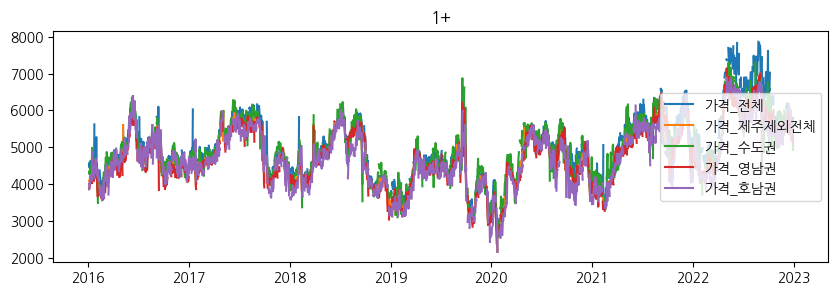

가격_전체 describe -> min : 2087.0 / max : 7732.0 / std : 887.6338827517814
가격_제주제외전체 describe -> min : 2087.0 / max : 6920.0 / std : 780.7917614764434
가격_수도권 describe -> min : 2425.0 / max : 7204.0 / std : 798.8581482253535
가격_영남권 describe -> min : 2264.0 / max : 7054.0 / std : 793.3766404138572
가격_호남권 describe -> min : 2087.0 / max : 6692.0 / std : 769.9312814696093


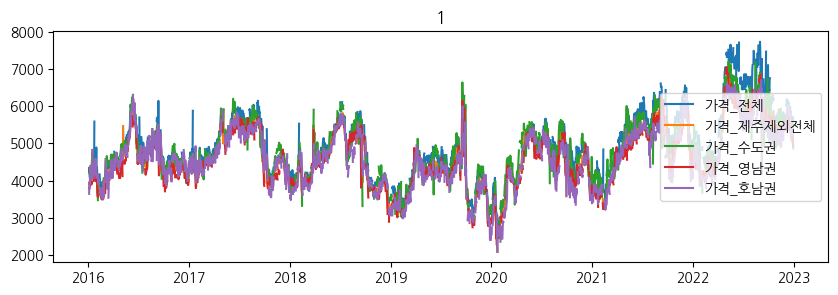

가격_전체 describe -> min : 1808.0 / max : 7861.0 / std : 906.7399784523707
가격_제주제외전체 describe -> min : 1808.0 / max : 6404.0 / std : 701.1344209769893
가격_수도권 describe -> min : 2186.0 / max : 6867.0 / std : 792.8810109003357
가격_영남권 describe -> min : 2040.0 / max : 6440.0 / std : 698.4517638784812
가격_호남권 describe -> min : 1808.0 / max : 6089.0 / std : 676.226253148221


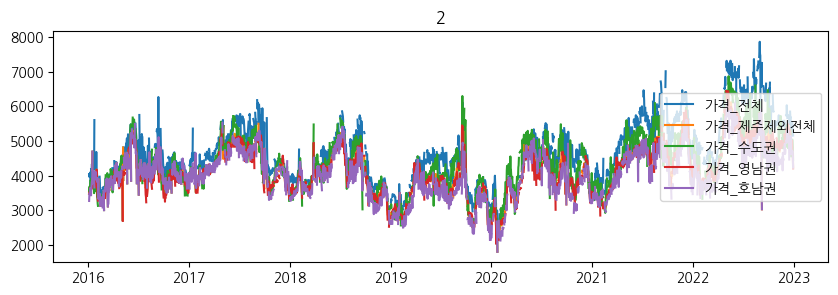

가격_전체 describe -> min : 991.0 / max : 4434.0 / std : 469.53183470189634
가격_제주제외전체 describe -> min : 676.0 / max : 4299.0 / std : 476.77981458433436
가격_수도권 describe -> min : 580.0 / max : 6369.0 / std : 824.7487499456687
가격_영남권 describe -> min : 1310.0 / max : 4549.0 / std : 476.2071537147023
가격_호남권 describe -> min : 600.0 / max : 5129.0 / std : 661.2307689180899


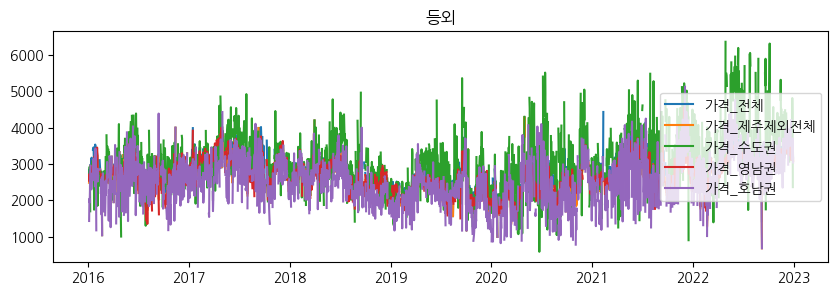

가격_전체 describe -> min : 2021.0 / max : 7735.0 / std : 884.9992566462585
가격_제주제외전체 describe -> min : 2021.0 / max : 6786.0 / std : 744.715817345595
가격_수도권 describe -> min : 2402.0 / max : 7107.0 / std : 801.6512338103599
가격_영남권 describe -> min : 2218.0 / max : 6861.0 / std : 742.0186034646894
가격_호남권 describe -> min : 2021.0 / max : 6425.0 / std : 710.8636190540728


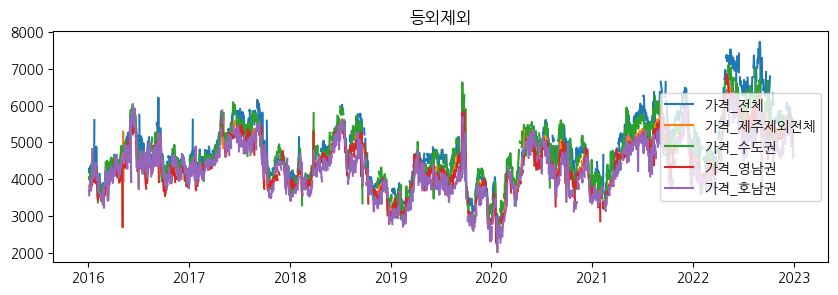

가격_전체 describe -> min : 233.0 / max : 7499.0 / std : 806.118444878341
가격_제주제외전체 describe -> min : 233.0 / max : 4799.0 / std : 787.3893198123384
가격_수도권 describe -> min : 599.0 / max : 4799.0 / std : 769.8807695786984
가격_영남권 describe -> min : 233.0 / max : 3790.0 / std : 649.1140664634023
가격_호남권 describe -> min : 0.0 / max : 5042.0 / std : 769.3024144801018


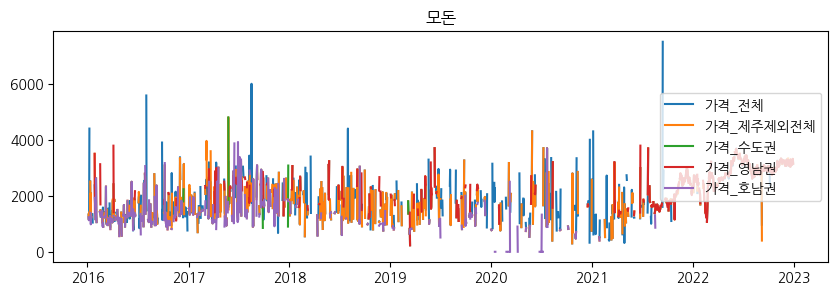

In [47]:
## 지역구 통합 및 전체 가격 시각화 -> 등외 제외와 모돈을 제외한 다른 등급에 대한 예측 진행
target_col = ['date','등급','가격_전체','가격_제주제외전체','가격_수도권','가격_영남권','가격_호남권']

temp_df = df[target_col].copy()
for grade in df['등급'].unique():
    temp_df_2 = temp_df[temp_df['등급'] == grade]
    temp_col = list(temp_df_2)
    temp_col.remove('date')
    temp_col.remove('등급')
    
    for col in temp_col:
        print(f'{col} describe -> min : {temp_df_2[col].min()} / max : {temp_df_2[col].max()} / std : {temp_df_2[col].std()}')
    plt.figure(figsize = (10,3))
    plt.plot(temp_df_2['date'], temp_df_2[temp_col])
    plt.title(grade)
    plt.legend(temp_col, loc = 'right')
    plt.show()    

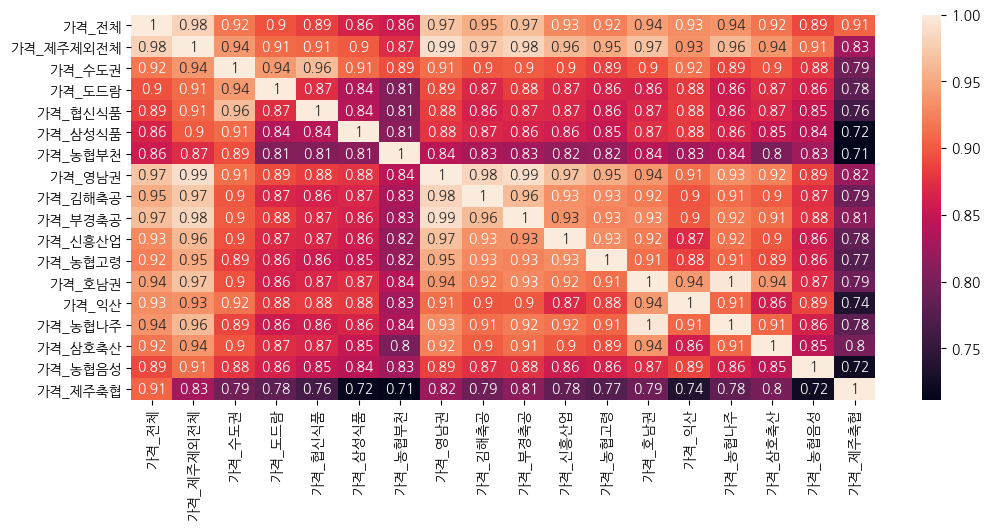

In [48]:
## 전체 관련된 컬럼이 다른 컬럼들을 대표할 수 있는지 확인 (상관분석)
## 가격 전체는 다른 가격의 대표성을 띈다고 할 수 있음
import seaborn as sns
plt.figure(figsize = (12,5))
sns.heatmap(df[[col for col in list(df) if '가격' in col]].corr(), annot = True)
plt.show()

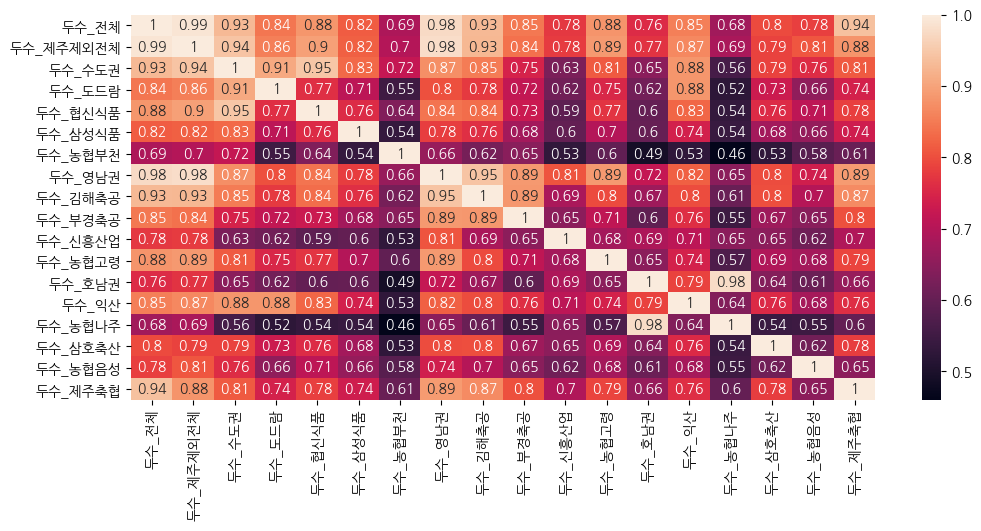

In [49]:
## 두수 전체는 다른 두수의 대표성을 띈다고 할 수 없음
plt.figure(figsize = (12,5))
sns.heatmap(df[[col for col in list(df) if '두수' in col]].corr(), annot = True)
plt.show()

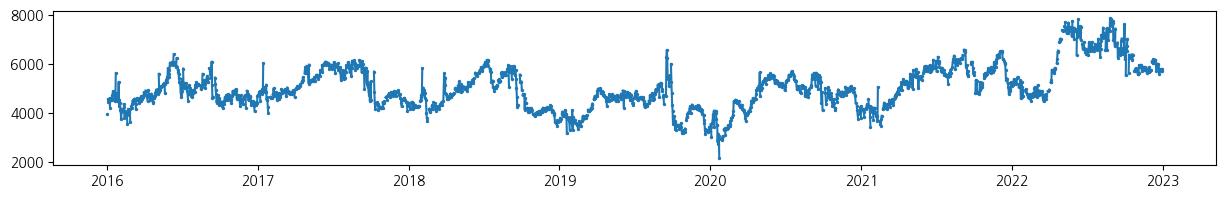

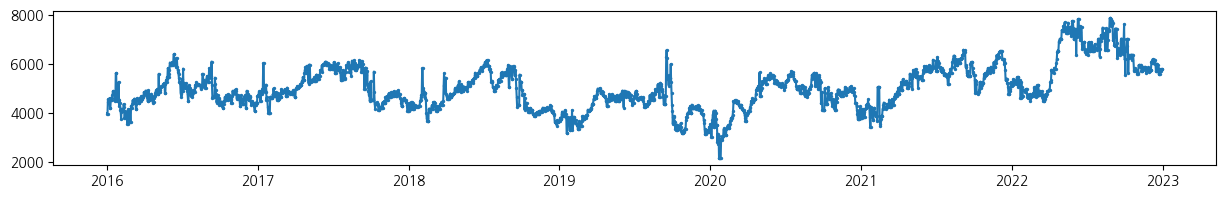

In [146]:
## Fill missing value
## 가격 상승/하락이 점진적으로 이루어지지 않기 때문에 선형보간법은 적합하지 않음, 따라서 전날의 값으로 공백값을 채우는 Front Fill 방법 적용
grade = '1+'
total_price = df[df['등급'] == grade]
total_price.reset_index(drop = True, inplace = True)
total_price.reset_index(drop = False, inplace = True)

plt.figure(figsize = (15,2))
plt.scatter(total_price['date'],total_price[['가격_전체']], s = 2)
plt.plot(total_price['date'],total_price[['가격_전체']])

plt.figure(figsize = (15,2))
plt.scatter(total_price['date'],total_price[['가격_전체']].fillna(method = 'ffill'), s = 2)
plt.plot(total_price['date'],total_price[['가격_전체']].fillna(method = 'ffill'))

# plt.figure(figsize = (15,2))
# plt.plot(total_price['date'],total_price[['가격_전체']].interpolate(method = 'linear'))

# knn_df = pd.DataFrame(columns = ['가격_전체','index'], data = KNNImputer(n_neighbors=20, weights = 'distance').fit_transform(total_price[['가격_전체','index']]))
# plt.figure(figsize = (15,2))
# plt.plot(total_price['date'],knn_df['가격_전체'])

plt.show()

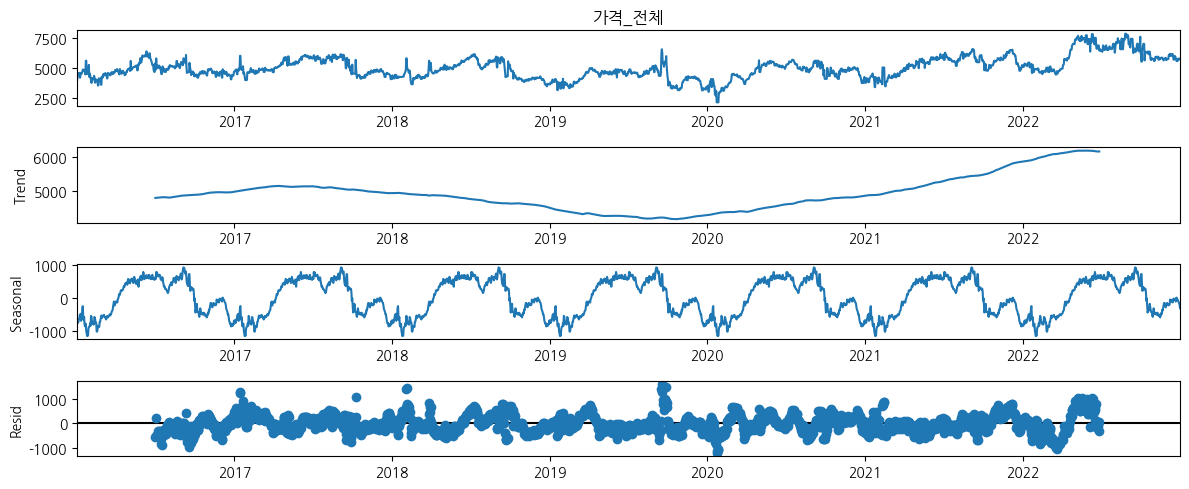

In [149]:
## 가격 전체에 대한 시계열 분석
## 여름에 가격이 높음 (돼지가 겨울에 강하기 때문에 개체수가 많아 가격이 저렴)
## 19년도 돼지 열병 & 20년도부터 코로나로 인한 돼지고기 금액 상승 (https://www.pignpork.com/news/articleView.html?idxno=4378)
from statsmodels.tsa.seasonal import seasonal_decompose
temp_df = total_price[['date', '가격_전체']].fillna(method = 'ffill')
temp_df = temp_df[1:]
temp_df.set_index('date', inplace = True)
result = seasonal_decompose(temp_df['가격_전체'], period = 365)
plt.rcParams['figure.figsize'] = [12, 5]
result.plot()
plt.show()

## Create Training Dataset

In [468]:
## 날짜 결측치 확인 -> 학습 : 0개, 테스트 : 19개
# set(pd.date_range(df['date'].min(), df['date'].max())) - set(df['date'])
set(pd.date_range(train_df['timestamp'].min(), train_df['timestamp'].max())) - set(train_df['timestamp'])
len(set(pd.date_range(test_df['date'].min(), test_df['date'].max())) - set(test_df['date']))

19

In [469]:
## 학습 대상 데이터 : 모돈/등외 제외한 가격 전체
forecast_df = pd.DataFrame()
forecast_df[['item_id','timestamp','demand']] = df[~df['등급'].isin(['모돈','등외'])][['등급','date','가격_전체']].copy()

## 데이터 분리 기준
time_limit = forecast_df['timestamp'].unique()[int(forecast_df['timestamp'].nunique()*0.8)]
print(f'time_limit : {time_limit}')

## 학습/테스트 데이터 분류
train_df = forecast_df[forecast_df['timestamp'] <= time_limit]
test_df = forecast_df[forecast_df['timestamp'] > time_limit]
print(f"학습 기간 : {train_df['timestamp'].nunique()} 일, 테스트 기간 : {test_df['timestamp'].nunique()}")

train_df.to_csv('s3://sagemaker-eightmeals/train_data/RETAIL/train_df.csv', index = False)
train_df.rename(columns = {'demand' : 'target_value'}, inplace = True)
train_df.to_csv('s3://sagemaker-eightmeals/train_data/CUSTOM/train_df.csv', index = False)

time_limit : 2021-07-23T00:00:00.000000000
학습 기간 : 2031 일, 테스트 기간 : 507


/opt/conda/lib/python3.7/site-packages/pandas/core/frame.py:5047: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [603]:
## 등급별 Front Fill 진행
ffill_df = pd.DataFrame()
for grade in train_df['item_id'].unique():
    temp_df = train_df[train_df['item_id'] == grade].sort_values('timestamp')
    temp_df.fillna(method = 'ffill', inplace = True)
    temp_df.fillna(method = 'bfill', inplace = True)
    ffill_df = pd.concat([ffill_df, temp_df])
    
ffill_df.to_csv('s3://sagemaker-eightmeals/train_data/RETAIL/ffill_df.csv', index = False)
ffill_df.rename(columns = {'demand' : 'target_value'}, inplace = True)
ffill_df.to_csv('s3://sagemaker-eightmeals/train_data/CUSTOM/ffill_df.csv', index = False)

In [604]:
## Quicksight용 데이터 저장
col_list = list(df)
col_list.remove('weekday')
col_list.remove('holiday')

quick_df = df[df['date'] <= time_limit][col_list].copy()
quick_df = pd.melt(quick_df, id_vars=['date', '등급'])
quick_df.rename(columns = {'variable': '구분'}, inplace = True)
quick_df.rename(columns = {'value': '가격/두수'}, inplace = True)

quick_df['가격/두수'] = np.where(quick_df['가격/두수'] == 'NaN', np.NaN, quick_df['가격/두수'])

quick_df.to_csv('s3://sagemaker-eightmeals/quicksight_data/quick_df.csv', index = False)

## Forecast Test

In [22]:
session = boto3.Session() 
region = session.region_name
forecast = session.client(service_name="forecast") 
forecast_query = session.client(service_name="forecastquery")
s3 = session.client(service_name="s3")

In [23]:
## Create Data groups
from contextlib import suppress

data_type_list = ['train','ffill']
domain_list = ['CUSTOM','RETAIL']

for data_type in data_type_list:
    for domain in domain_list:
        print(data_type, domain)
        if domain == 'RETAIL':
            schema = {"Attributes": [{"AttributeName": "item_id", "AttributeType": "string"},
                                     {"AttributeName": "timestamp", "AttributeType": "timestamp"},
                                     {"AttributeName": "demand", "AttributeType": "float"}]}
        elif domain == 'CUSTOM':
            schema = {"Attributes": [{"AttributeName": "item_id", "AttributeType": "string"},
                                     {"AttributeName": "timestamp", "AttributeType": "timestamp"},
                                     {"AttributeName": "target_value", "AttributeType": "float"}]}        
        
        with suppress(Exception): dataset = forecast.create_dataset(DatasetName = f'mzc_{data_type}_{domain}',
                                                                    Domain = domain,
                                                                    DatasetType = 'TARGET_TIME_SERIES',
                                                                    DataFrequency = '1D',
                                                                    Schema = schema)
            
        with suppress(Exception): dataset_arn = [dataset_arn['DatasetArn'] for dataset_arn in forecast.list_datasets()['Datasets'] if ('mzc' in dataset_arn['DatasetArn']) 
                                                                                                            & (data_type in dataset_arn['DatasetArn']) 
                                                                                                            & (domain in dataset_arn['DatasetArn'])]
        print(dataset_arn)
        with suppress(Exception): dataset_group = forecast.create_dataset_group(DatasetGroupName = f'mzc_{data_type}_{domain}',
                                                                                Domain = domain, DatasetArns = dataset_arn)

        with suppress(Exception): dataset_import = forecast.create_dataset_import_job(DatasetImportJobName = f'mzc_{data_type}_{domain}_import',
                                                                                      DatasetArn = dataset_arn[0],
                                                                                      DataSource = {"S3Config": {"Path": f"s3://sagemaker-eightmeals/train_data/{domain}/{data_type}_df.csv",
                                                                                                                 "RoleArn": "arn:aws:iam::533071443667:role/service-role/AmazonForecast-ExecutionRole-1676338105732"}},
                                                                                      TimestampFormat = "yyyy-MM-dd",
                                                                                      TimeZone = 'Asia/Seoul')        

train CUSTOM
['arn:aws:forecast:ap-northeast-2:533071443667:dataset/mzc_train_CUSTOM']
train RETAIL
['arn:aws:forecast:ap-northeast-2:533071443667:dataset/mzc_train_RETAIL']
ffill CUSTOM
['arn:aws:forecast:ap-northeast-2:533071443667:dataset/mzc_ffill_CUSTOM']
ffill RETAIL
['arn:aws:forecast:ap-northeast-2:533071443667:dataset/mzc_ffill_RETAIL']


In [25]:
# ## Create Forecast models
# algorithm_list = ['CNN-QR','Deep_AR_Plus','Prophet']
# datagroup_arn_list = [datagroup_arn['DatasetGroupArn'] for datagroup_arn in forecast.list_dataset_groups()['DatasetGroups'] if 'mzc' in datagroup_arn['DatasetGroupArn']]

# loop = 1
# while loop == 1:
#     for datagroup_arn in datagroup_arn_list:
#         name = datagroup_arn.split('/')[-1].split("_")
#         print(name)
#         ## Create Predictor (AutoML model)
#         with suppress(Exception): auto_predictor = forecast.create_auto_predictor(PredictorName=f'{name[1]}_{name[2]}_automl_horizon_30', ForecastHorizon=500,
#                                                                                   DataConfig = {'DatasetGroupArn' : datagroup_arn},ForecastFrequency = 'D')
#         ## Create Predictor (single model)
#         if name[2] == 'RETAIL':
#             feturization = {'AttributeName': 'demand'}
#         elif name[2] == 'CUSTOM':
#             feturization = {'AttributeName': 'target_value'}                               
#         for algorithm in algorithm_list:                
#             with suppress(Exception): predictor = forecast.create_predictor(PredictorName=f"{name[1]}_{name[2]}_{algorithm.split('-')[0]}_horizon_30",
#                                                                             AlgorithmArn=f"arn:aws:forecast:::algorithm/{algorithm}",
#                                                                             ForecastHorizon=500, ## 몇일 치의 데이터를 볼 것인가
#                                                                             InputDataConfig={'DatasetGroupArn': datagroup_arn, 'SupplementaryFeatures': [{'Name': 'holiday', 'Value': 'KR'}]},
#                                                                             FeaturizationConfig={'ForecastFrequency': 'D', 'Featurizations': [feturization]})    
#     ## Create Forecast
#     for predictor_arn in [predictor['PredictorArn'] for predictor in forecast.list_predictors()['Predictors'] if (predictor['Status'] == 'ACTIVE') & (predictor['PredictorArn'].split('/')[-1].split('_')[0] in data_type_list) & (predictor['PredictorArn'].split('/')[-1].split('_')[1] in domain_list)]:
#         with suppress(Exception): forecast.create_forecast(ForecastName = '_'.join(predictor_arn.split('/')[-1].split('_')[:3]) + '_forecast', PredictorArn = predictor_arn)


In [517]:
# ## Create Forecast Export Job
# for forecast_arn in [forecastarn['ForecastArn'] for forecastarn in forecast.list_forecasts()['Forecasts'] 
#                      if (forecastarn['Status'] == 'ACTIVE') 
#                      & (forecastarn['ForecastArn'].split('/')[-1].split('_')[0] in data_type_list) 
#                      & (forecastarn['ForecastArn'].split('/')[-1].split('_')[1] in domain_list)]:
#     # print(forecast_arn)
#     print(f"s3://sagemaker-eightmeals/forecast_results/{forecast_arn.split('/')[-1].split('_')[0]}/{forecast_arn.split('/')[-1].split('_')[1]}")
#     try: forecast.create_forecast_export_job(ForecastExportJobName = forecast_arn.split('/')[-1] + '_import',
#                                                                   ForecastArn = forecast_arn,
#                                                                   Destination = {"S3Config": {"Path": f"s3://sagemaker-eightmeals/forecast_results/{forecast_arn.split('/')[-1].split('_')[0]}/{forecast_arn.split('/')[-1].split('_')[1]}",
#                                                                                               "RoleArn": "arn:aws:iam::533071443667:role/service-role/AmazonForecast-ExecutionRole-1676338105732"}})
    
#     except Exception as e:
#         print(e)

In [519]:
# len([export_job['ForecastExportJobArn'] for export_job in forecast.list_forecast_export_jobs()['ForecastExportJobs'] if (export_job['ForecastExportJobArn'].split('/')[-1].split('_')[0] in data_type_list) & (export_job['ForecastExportJobArn'].split('/')[-1].split('_')[1] in domain_list)])

## Delete Resource

In [153]:
# ## Delete Predictor All
# for predictor_arn in [predictor['PredictorArn'] for predictor in forecast.list_predictors()['Predictors'] if ('ACTIVE' == predictor['Status']) & ((predictor['PredictorArn'].split('/')[-1].split('_')[0] in data_type_list) | (predictor['PredictorArn'].split('/')[-1].split('_')[1] in domain_list))]:
#     print(predictor_arn)
#     try:        
#         forecast.delete_predictor(PredictorArn = predictor_arn)
#     except Exception as e:
#         print(e)
#         pass
# ## Delete Forecast All
# for forecast_arn in [forecast['ForecastArn'] for forecast in forecast.list_forecasts()['Forecasts'] if (forecast['ForecastArn'].split('/')[-1].split("_")[0] in data_type_list) & (forecast['ForecastArn'].split('/')[-1].split("_")[1] in domain_list)]:
#     print(forecast_arn)
#     try:
#         forecast.delete_forecast(ForecastArn = forecast_arn)
#     except Exception as e:
#         print(e)
#         pass
# ## Delete Forecast Export Job All
# for export_arn in [export_job['ForecastExportJobArn'] for export_job in forecast.list_forecast_export_jobs()['ForecastExportJobs'] if (export_job['ForecastExportJobArn'].split('/')[-1].split('_')[0] in data_type_list) & (export_job['ForecastExportJobArn'].split('/')[-1].split('_')[1] in domain_list)]:
#     print(export_arn)
#     forecast.delete_forecast_export_job(ForecastExportJobArn = export_arn)

## Results Check

### Forecast Metrics

In [ ]:
results_df = pd.DataFrame(columns = ['Data','Algorithm','WAPE','RMSE','MASE','MAPE'])
for predictor_arn in [predictor['PredictorArn'] for predictor in forecast.list_predictors()['Predictors'] 
                      if ('ACTIVE' == predictor['Status']) & ((predictor['PredictorArn'].split('/')[-1].split('_')[0] in data_type_list) | 
                                                              (predictor['PredictorArn'].split('/')[-1].split('_')[1] in domain_list))]:
    
    temp_metrics = forecast.get_accuracy_metrics(PredictorArn = predictor_arn)['PredictorEvaluationResults'][0]['TestWindows'][0]['Metrics']['ErrorMetrics'][0]
    results_df = pd.concat([results_df, pd.DataFrame([{'Data' : '_'.join(predictor_arn.split("/")[-1].split("_")[:2]),
                                                       'Algorithm' : predictor_arn.split("/")[-1].split("_")[2],
                                                       'WAPE' : temp_metrics['WAPE'],
                                                       'RMSE' : temp_metrics['RMSE'],
                                                       'MASE' : temp_metrics['MASE'],
                                                       'MAPE' : temp_metrics['MAPE']}])])
results_df.sort_values(['RMSE','MAPE'],ascending=True, inplace = True)
results_df.reset_index(drop = True, inplace = True)

### Custom Test


In [588]:
def filter_grade(df, grade):
    if 'timestamp' in list(df):
        df.rename(columns = {'timestamp':'date'}, inplace = True)
    else:
        pass
    temp_test = df[df['item_id'] == grade].copy()
    temp_test.sort_values(['date'], inplace = True)
    temp_test.reset_index(drop = True, inplace = True)
    return temp_test

def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true))

In [638]:
results_metrics = pd.DataFrame(columns = ['grade', 'Data', 'Algorithm', 'RMSE', 'MAPE'])

domain_list = ['RETAIL','RETAIL','CUSTOM','CUSTOM','RETAIL']
data_type_list = ['ffill','ffill','ffill','train','train']
algorithm_list = ['automl','CNN','CNN','CNN','automl']
grade_list = ['1+', '1', '2', '등외제외']

for i in range(len(domain_list)):    
    domain = domain_list[i]
    data_type = data_type_list[i]
    algorithm = algorithm_list[i]
    
    s3_client = boto3.client('s3')
    objects_list = s3_client.list_objects_v2(Bucket='sagemaker-eightmeals')
    objects_list = [obj['Key'] for obj in objects_list['Contents'] if (algorithm in obj['Key'].split('/')[-1]) & (data_type in obj['Key'].split('/')[-1]) & (domain in obj['Key'].split('/')[-1])]

    results_df = pd.DataFrame()

    for obj in objects_list: 
        print(f's3://sagemaker-eightmeals/{obj}')
        results_df = pd.concat([results_df, wr.s3.read_csv(f's3://sagemaker-eightmeals/{obj}')])        

    ## 날짜 데이터 형변환
    results_df['date'] = results_df.apply(lambda x : x['date'][:10], axis = 1)
    results_df['date'] = pd.to_datetime(results_df['date'])
    results_df['item_id'] = results_df['item_id'].astype('str')
    for grade in grade_list:
        # grade = '1+'    
        actual_df = filter_grade(test_df, grade)
        predict_df = filter_grade(results_df, grade)           
        total_results = pd.merge(actual_df, predict_df, on ='date')
        total_results = total_results[~total_results['demand'].isna()].copy()
#         RMSE = mean_squared_error(total_results['demand'], total_results['p50'])**0.5
#         MAPE = mean_absolute_percentage_error(total_results['demand'], total_results['p50'])

#         results_metrics = pd.concat([results_metrics, pd.DataFrame([{'grade' : grade, 'Data' : data_type+'_'+domain, 'Algorithm' : algorithm, 'RMSE' : RMSE, 'MAPE' : MAPE}])])
# results_metrics.to_csv('final_metrics.csv')

s3://sagemaker-eightmeals/forecast_results/ffill/RETAIL/ffill_RETAIL_automl_forecast_import_2023-02-20T09-19-59Z_part0.csv
s3://sagemaker-eightmeals/forecast_results/ffill/RETAIL/ffill_RETAIL_automl_forecast_import_2023-02-20T09-19-59Z_part1.csv
s3://sagemaker-eightmeals/forecast_results/ffill/RETAIL/ffill_RETAIL_automl_forecast_import_2023-02-20T09-19-59Z_part2.csv
s3://sagemaker-eightmeals/forecast_results/ffill/RETAIL/ffill_RETAIL_automl_forecast_import_2023-02-20T09-19-59Z_part3.csv


## Create Quicksight Insert Data

In [648]:
## 최종 모델 데이터
domain = 'RETAIL'
data_type = 'ffill'
algorithm = 'CNN'

s3_client = boto3.client('s3')
objects_list = s3_client.list_objects_v2(Bucket='sagemaker-eightmeals')
objects_list = [obj['Key'] for obj in objects_list['Contents'] if (algorithm in obj['Key'].split('/')[-1]) & (data_type in obj['Key'].split('/')[-1]) & (domain in obj['Key'].split('/')[-1])]

results_df = pd.DataFrame()

for obj in objects_list: 
    print(f's3://sagemaker-eightmeals/{obj}')
    results_df = pd.concat([results_df, wr.s3.read_csv(f's3://sagemaker-eightmeals/{obj}')])        

## 날짜 데이터 형변환
results_df['date'] = results_df.apply(lambda x : x['date'][:10], axis = 1)
results_df['date'] = pd.to_datetime(results_df['date'])
results_df['item_id'] = results_df['item_id'].astype('str')

s3://sagemaker-eightmeals/forecast_results/ffill/RETAIL/ffill_RETAIL_CNN_forecast_import_2023-02-23T08-52-29Z_part0.csv
s3://sagemaker-eightmeals/forecast_results/ffill/RETAIL/ffill_RETAIL_CNN_forecast_import_2023-02-23T08-52-29Z_part1.csv
s3://sagemaker-eightmeals/forecast_results/ffill/RETAIL/ffill_RETAIL_CNN_forecast_import_2023-02-23T08-52-29Z_part2.csv
s3://sagemaker-eightmeals/forecast_results/ffill/RETAIL/ffill_RETAIL_CNN_forecast_import_2023-02-23T08-52-29Z_part3.csv


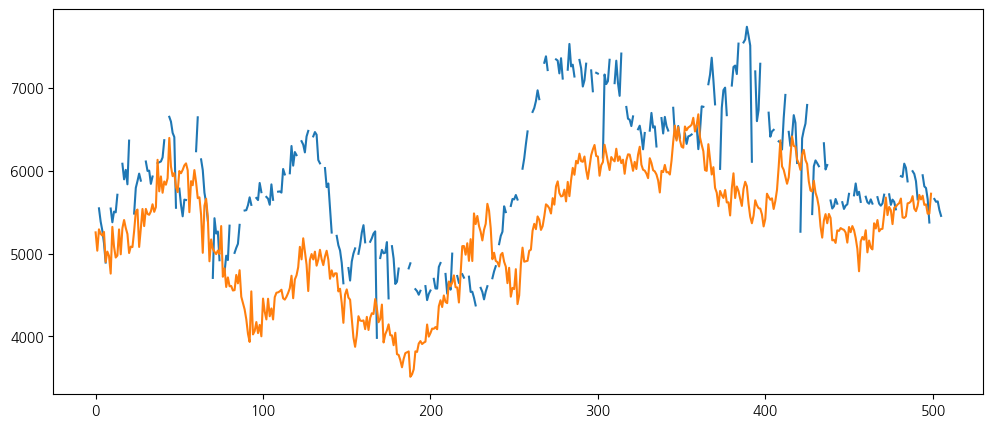

In [661]:
plt.plot(test_df[test_df['item_id'] == '등외제외'].reset_index()['demand'])
plt.plot(results_df[results_df['item_id'] == '등외제외'].reset_index()['p50'])
plt.show()

0      5333.674316
1      5120.683105
2      5371.115234
3      5314.343750
4      5289.454102
          ...     
495    5601.416016
496    5606.180176
497    5489.584473
498    5495.595215
499    5749.533691
Name: p50, Length: 500, dtype: float64

In [634]:
results_df.rename(columns = {'item_id' : '등급', 'p50':'가격/두수'}, inplace = True)
results_df['구분'] = '가격_전체'
results_df = results_df[['date', '등급', '구분', '가격/두수']].copy()
# results_df.to_csv('s3://sagemaker-eightmeals/quicksight_data/forecast_df.csv', index = False)
temp_df = results_df[['date','구분']].drop_duplicates()
temp_df['등급'] = '모돈'
temp_df['가격/두수'] = np.NaN
results_df = pd.concat([results_df, temp_df])
temp_df = results_df[['date','구분']].drop_duplicates()
temp_df['등급'] = '등외'
temp_df['가격/두수'] = np.NaN
results_df = pd.concat([results_df, temp_df])

In [636]:
pd.concat([quick_df, results_df]).to_csv('s3://sagemaker-eightmeals/quicksight_data/quick_df.csv', index = False)